# Root reinforcement predictions



## Initialise code

In [1]:
# load packages and functions
import matplotlib.pyplot as plt
from pyrootmemo.io import read_csv_roots
from pyrootmemo.fit import Powerlaw
from pyrootmemo.materials import Soil, Interface
from pyrootmemo.geometry import SoilProfile, FailureSurface
from pyrootmemo.models import Wwm, Fbm, Rbmw, Waldron
# define parameter object (value + unit), used later to define soil, root and geometry objects
from collections import namedtuple
Parameter = namedtuple("parameter", "value unit")

## Load data

By default, this script uses data for core experiments by Bull et al. There are two files to load, one for biomechanical testing , and describing the diameters of all roots in the ground. 

Alternatively, you can read in your own data by placing a comma seperated .csv files in the project folder and adjusting the paths below. 

* The .csv file describing all roots in the ground should contain columns for
  * `diameter_unit`: the diameter of the root
* The .csv file describing biomechanical data should contain columns for:
  * `diameter_unit`: the diameter of the tested root
  * `tensile_strenght_unit`: the tensile strength of the tested root
  * `elastic_modulus_unit`: the (elastic) stiffnes of the tested root
  * `length_unit`: the (anchored) length of the root (can be assumed if needed)

The part of the column name indicated by 'unit' must be replaced by the measurement unit, e.g. 'mm'.

data_field = read_csv_roots('data/')
data_biomech = read_csv_roots('data/')

## Biomechanics

### Load data

(array([1., 0., 1., 0., 1., 0., 1., 0., 0., 1.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

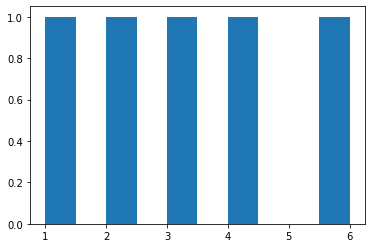

In [2]:
# load tensile strength data from csv
roots_tensile = read_csv_roots('data/test_tensile_data.csv')
# plot histogram of root diameters in tensile strength data
plt.hist(roots_tensile.diameter)

### Tensile strength

Multiplier: 10.302108727507983 megapascal
Exponent: -0.26777222766921593


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Diameter [mm]', ylabel='Tensile strength [MPa]'>)

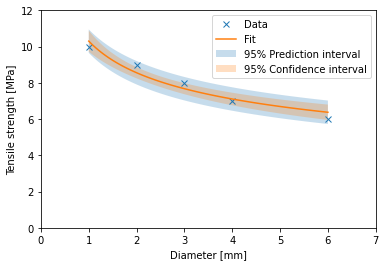

In [3]:
# define fit type
fit_model = 'normal'
# generate tensile strength fit
fit_tensile_strength = Powerlaw(
    roots_tensile.diameter, 
    roots_tensile.tensile_strength, 
    model = fit_model
    )
# show results
print('Multiplier:', fit_tensile_strength.multiplier)
print('Exponent:', fit_tensile_strength.exponent)
fit_tensile_strength.plot(prediction = True)

### Elastic modulus

Multiplier: 202.8574171108736 megapascal
Exponent: -0.12312827400589703


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Diameter [mm]', ylabel='Elastic modulus [MPa]'>)

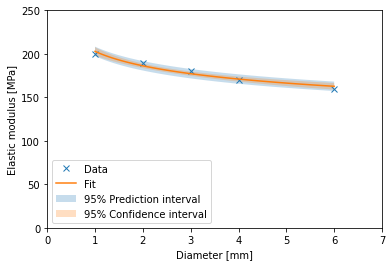

In [4]:
# generate fit
fit_elastic_modulus = Powerlaw(
    roots_tensile.diameter, 
    roots_tensile.elastic_modulus, 
    model = fit_model
    )
# show results
print('Multiplier:', fit_elastic_modulus.multiplier)
print('Exponent:', fit_elastic_modulus.exponent)
fit_elastic_modulus.plot(prediction = True, ylabel = 'Elastic modulus')

### Root length

Multiplier: 520.8755248020618 millimeter
Exponent: -0.08348218956181525


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Diameter [mm]', ylabel='Root length [mm]'>)

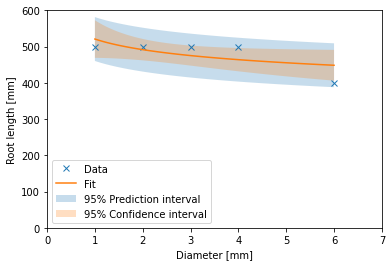

In [5]:
# generate fit
fit_length = Powerlaw(
    roots_tensile.diameter, 
    roots_tensile.length, 
    model = fit_model
    )
# show results
print('Multiplier:', fit_length.multiplier)
print('Exponent:', fit_length.exponent)
fit_length.plot(prediction = True, ylabel = 'Root length', yunit = 'mm')

## Reinforcement predictions

### Load data and define the problem

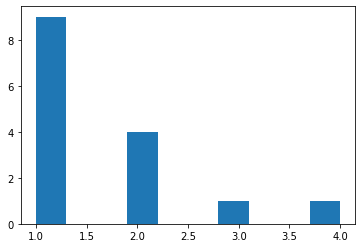

In [6]:
# load data
roots_field = read_csv_roots('data/test_field_data.csv')
# plot histogram of diameter
plt.hist(roots_field.diameter)
# make predictions for root properties using fitted power laws
roots_field.tensile_strength = fit_tensile_strength.predict(roots_field.diameter)
roots_field.elastic_modulus = fit_elastic_modulus.predict(roots_field.diameter)
roots_field.length = fit_length.predict(roots_field.diameter)

In [7]:
# define interface
interface = Interface(
    shear_strength = Parameter(10.0, 'kPa')
)

In [8]:
# define soils
soil = Soil(
    'test',
    cohesion = Parameter(2.0, 'kPa'),
    friction_angle = Parameter(30, 'deg')
    )
# define soil profile
soil_profile = SoilProfile(
    [soil],
    depth = Parameter([100], 'm')
    )

In [9]:
# define a failure surface
failure_surface = FailureSurface(
    depth = Parameter(1.0, 'm'),
    cross_sectional_area = Parameter(1.0, 'm^2'),
    shear_zone_thickness = Parameter(5.0, 'mm')
    )

### Wu/Waldron Model

In [10]:
# generate WWM object
wwm = Wwm(roots_field)
# calculate reinforcement
reinforcement = wwm.peak_reinforcement(
    failure_surface,
    k = 1.2
    )
print(reinforcement.to('kPa'))

0.38871325141943447 kilopascal


### Fibre bundle model

285.0104440162393 newton
0.2850104440162393 kilopascal


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Force in reference root [N]', ylabel='Total force in root bundle [N]'>)

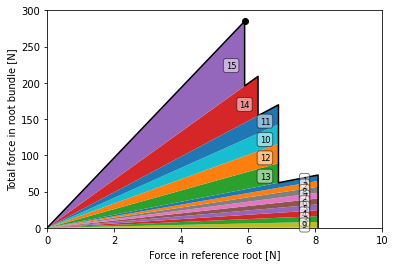

In [11]:
# define load sharing factor
load_sharing = 2.0 + fit_elastic_modulus.exponent - fit_length.exponent
# generate FBM object
fbm = Fbm(roots_field, load_sharing)
# calculate peak force and reinforcement
print(fbm.peak_force().to('N'))
print(fbm.peak_reinforcement(failure_surface, k = 1.0).to('kPa'))
# show mobilisation of forces
fbm.plot(peak = True, stack = True, labels = True)

### RBMw

232.4923338713604 newton
0.2324923338713604 kilopascal


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Pull-out displacement [mm]', ylabel='Total force in root bundle [N]'>)

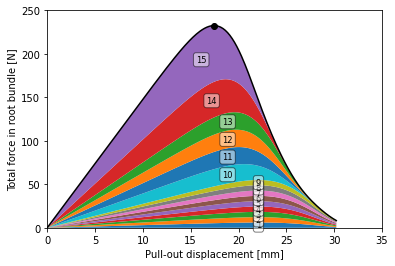

In [12]:
# define the Weibull shape factor
weibull_shape = 10.0
# generate RBMw object
rbmw = Rbmw(roots_field, weibull_shape)
# calculate peak reinforcement
print(rbmw.peak_force().to('N'))
print(rbmw.peak_reinforcement(failure_surface, k = 1.0).to('kPa'))
# plot how reinforcement mobilises with pullout displacement
rbmw.plot(stack = True, labels = True)

### Waldron

Shear displacement at peak: 17.366246278361043 millimeter
Peak reinforcement: 0.28922299052569045 kilopascal


(<Figure size 432x288 with 1 Axes>,
 <Axes: xlabel='Shear displacement [mm]', ylabel='Reinforcement [kPa]'>)

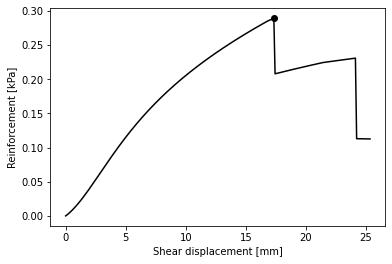

In [13]:
# generate Waldron model object
waldron = Waldron(roots_field, interface, soil_profile, failure_surface)
# peak reinforcement
peak = waldron.peak_reinforcement() 
print('Shear displacement at peak:', peak[0].to('mm'))
print('Peak reinforcement:', peak[1].to('kPa'))
# plot
waldron.plot()